# Importing packages

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
from sys import getsizeof
import itertools
import scipy.interpolate as intrp
from scipy.optimize import minimize
import pandas as pd
import time
from numpy import linalg as LA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import KernelPCA, PCA
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# A few functions and definitions

In [122]:
#This functions computes the euclidean distance of a generic configuration to the beamform solutions plane.
#Alpha and Beta are orthogonal generators of this plane
def unbeamness (d):
    alpha=[1,2,0,1,2,0,1,2]
    beta=[-3,-6,5,2,-1,10,7,4]
    appo=3000000000
    al2 = np.dot(alpha,alpha)
    be2 = np.dot(beta,beta)
    for iy in itertools.product([-360,0,360],repeat=8):
       o=d+np.array(iy)
       appo=min([appo,np.sqrt((-(np.dot(alpha,o))**2)/al2-((np.dot(beta,o))**2)/be2+np.dot(o,o))])
    return appo

#This function computes and diagonalizes the average hessian of array X, essentially it finds flat directions in a rehular array
def flattitude (X):
    X=np.array(X)
    nv=len(X.shape)
    #print(nv)
    Y=np.array(np.gradient(X,edge_order=2))
    #print(Y.shape)
    Z=np.concatenate(np.array([np.gradient(Y[ii],edge_order=2) for ii in range(nv)]))
    #print(Z.shape)
    #print(np.sum(Z,axis=tuple(range(1,nv+1))).shape)
    U=LA.eigh(np.sum(Z,axis=tuple(range(1,nv+1))).reshape(nv,nv))
    return U#[0]/np.sqrt(abs((U[0][0]*U[0][1]))),U[1]]

phin=('phi #0,1','phi #0,2','phi #1,0','phi #1,1','phi #1,2','phi #2,0','phi #2,1','phi #2,2')

#this simply computes the distance between configurations on a torus
def distp(x,y):
    V1808=np.array([180 for iii in range(len(x))])
    return np.sqrt(np.sum((np.mod(x-y+V1808,360)-V1808)**2))

#this simply computes the distance between lists of configurations on a torus
def distan(X,Y):
    V1808=np.array([180 for iii in range(len(X[0]))])
    return np.array([[np.sqrt(np.sum((np.mod(j-k+V1808,360)-V1808)**2)) for j in X] for k in Y])

# Examples of usage

In [5]:
X=np.array([[[(i+j+k)**2 for i in range(-100,100)] for j in range(-100,100)] for k in range(-100,100)])
flattitude(X)

(array([ -1.12639730e-08,   1.95074723e-09,   4.80000000e+07]),
 array([[-0.81377025, -0.06666816,  0.57735027],
        [ 0.34914881,  0.73807979,  0.57735027],
        [ 0.46462144, -0.67141163,  0.57735027]]))

In [4]:
distan(np.array([[2,5,0,56,60,30,90,213],[12,55,30,16,60,31,90,213]]),np.array([[2,50,56,156,10,130,190,203]]))

array([[ 194.32189789,  206.88644228]])

In [3]:
unbeamness([12,55,30,16,60,31,90,213])

111.49887891813083

# Loading the data

In [3]:
G0=h5py.File('3x3_data_9_15_16.h5','r')
B0=h5py.File('3x3_beam_data.h5','r')
G1=h5py.File('3x3_data_9_21_16.h5','r')
B1=h5py.File('3x3_beam_data_9_21_16.h5','r')
G2=h5py.File('data_3x3_9_23_16.h5','r')
B2=h5py.File('3x3_beam_data_9_23_16.h5','r')
G3=h5py.File('data_3x3_9_24_16.h5','r')
B3=h5py.File('3x3_beam_data_9_24_16.h5','r')
nG0=np.array(G0.get('/'))
nG1=np.array(G1.get('/'))
G0D=np.concatenate(np.array([np.array(G0.get(x)) for x in nG0]),axis=0)
B0D=np.concatenate(B0.get('beam_data'))
G1D=np.concatenate(np.array([np.array(G1.get(x)) for x in nG1]),axis=0)
B1D=np.concatenate(B1.get('beam_data'))
G2D=np.array(G2.get('data')).reshape(4194304,10)
B2D=np.concatenate(B2.get('beam_data'))
G3D=np.array(G3.get('data')).reshape(4194304,10)
B3D=np.concatenate(B3.get('beam_data'))
G0DS=G0D[G0D[:,9].argsort()]
B0DS=B0D[B0D[:,9].argsort()]
G1DS=G1D[G1D[:,9].argsort()]
B1DS=B1D[B1D[:,9].argsort()]
G2DS=G2D[G2D[:,9].argsort()]
B2DS=B2D[B2D[:,9].argsort()]
G3DS=G3D[G3D[:,9].argsort()]
B3DS=B3D[B3D[:,9].argsort()]
del G0D, G1D, G2D, G3D, B0D, B1D, B2D, B3D
G0DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in G0DS])
B0DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in B0DS])
G1DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in G1DS])
B1DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in B1DS])
G2DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in G2DS])
B2DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in B2DS])
G3DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in G3DS])
B3DSS=np.array([np.mod(qq[1:9]-qq[0]*np.array([1,1,1,1,1,1,1,1]),360) for qq in B3DS])

# Check for uniformity of sampling

(array([ 279197.,  279784.,  279152.,  279590.,  279374.,  279095.,
         279417.,  279753.,  280525.,  279726.,  279553.,  279850.,
         279662.,  279043.,  280583.]),
 array([  5.11169434e-04,   2.40004751e+01,   4.80004389e+01,
          7.20004028e+01,   9.60003667e+01,   1.20000331e+02,
          1.44000294e+02,   1.68000258e+02,   1.92000222e+02,
          2.16000186e+02,   2.40000150e+02,   2.64000114e+02,
          2.88000078e+02,   3.12000042e+02,   3.36000006e+02,
          3.59999969e+02]),
 <a list of 15 Patch objects>)

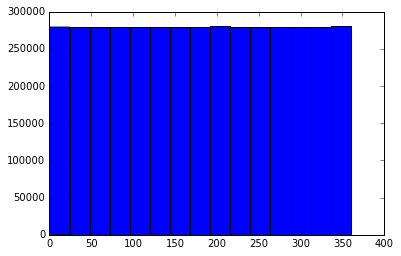

In [196]:
%matplotlib inline
plt.hist(G3DSS[:,0], bins=15)

### CONCLUSION: looks uniform to me

# The following concerns characterizing the landscape of the phase space by "clustering" methods

In [135]:
oo=G2DS #choose a dataset from G0DS, G1DS, G2DS, G3DS
oob=B2DS #choose a dataset from B0DS, B1DS, B2DS, B3DS
oos=G2DSS #choose a dataset from G0DSS, G1DSS, G2DSS, G3DSS
oobs=B2DSS #choose a dataset from B0DSS, B1DSS, B2DSS, B3DSS

num=500
numB=30

oop=oos[0:num]
oobp=oobs[0:numB]
oobpc=np.concatenate([oop,oobp])

#the following are distance matrices between pairs of points in different subsets

DistC=distan(oobpc,oobpc)
Dist=distan(oop,oop)
DistB=distan(oop,oobp)
DistBB=distan(oobp,oobp)

### Expected average nearest-neighbor distance among all the samples

In [131]:
360/np.power(len(G2DSS),1./8.) #it's 360 divided by how many samples per dimension there are

53.51432017512245

### Average nearest-neighbor distance among the highest-power general solutions

In [134]:
np.mean([np.min([iii for iii in ii if iii!=0.0]) for ii in Dist])

65.117673773300965

### CONCLUSION: if the average nearest neighbor distance between high-power points is around the same as the average for the entire data set, then the space is likely convex (maxima are lumped up in a solid region basically)

## The following is an alternative way around it, basically you can cluster up with dbscan and count how many clusters you get, if it's only one cluster, the space is convex

In [350]:
dbc=DBSCAN(eps=80,metric='precomputed').fit(DistC)
db=DBSCAN(eps=80,metric='precomputed').fit(Dist)
dbb=DBSCAN(eps=80,metric='precomputed').fit(DistBB)

# Plotting highest-power points as scatter plots depending on all possible pairs of phases. Basically it's a slice of the dataset at a certain power interval.

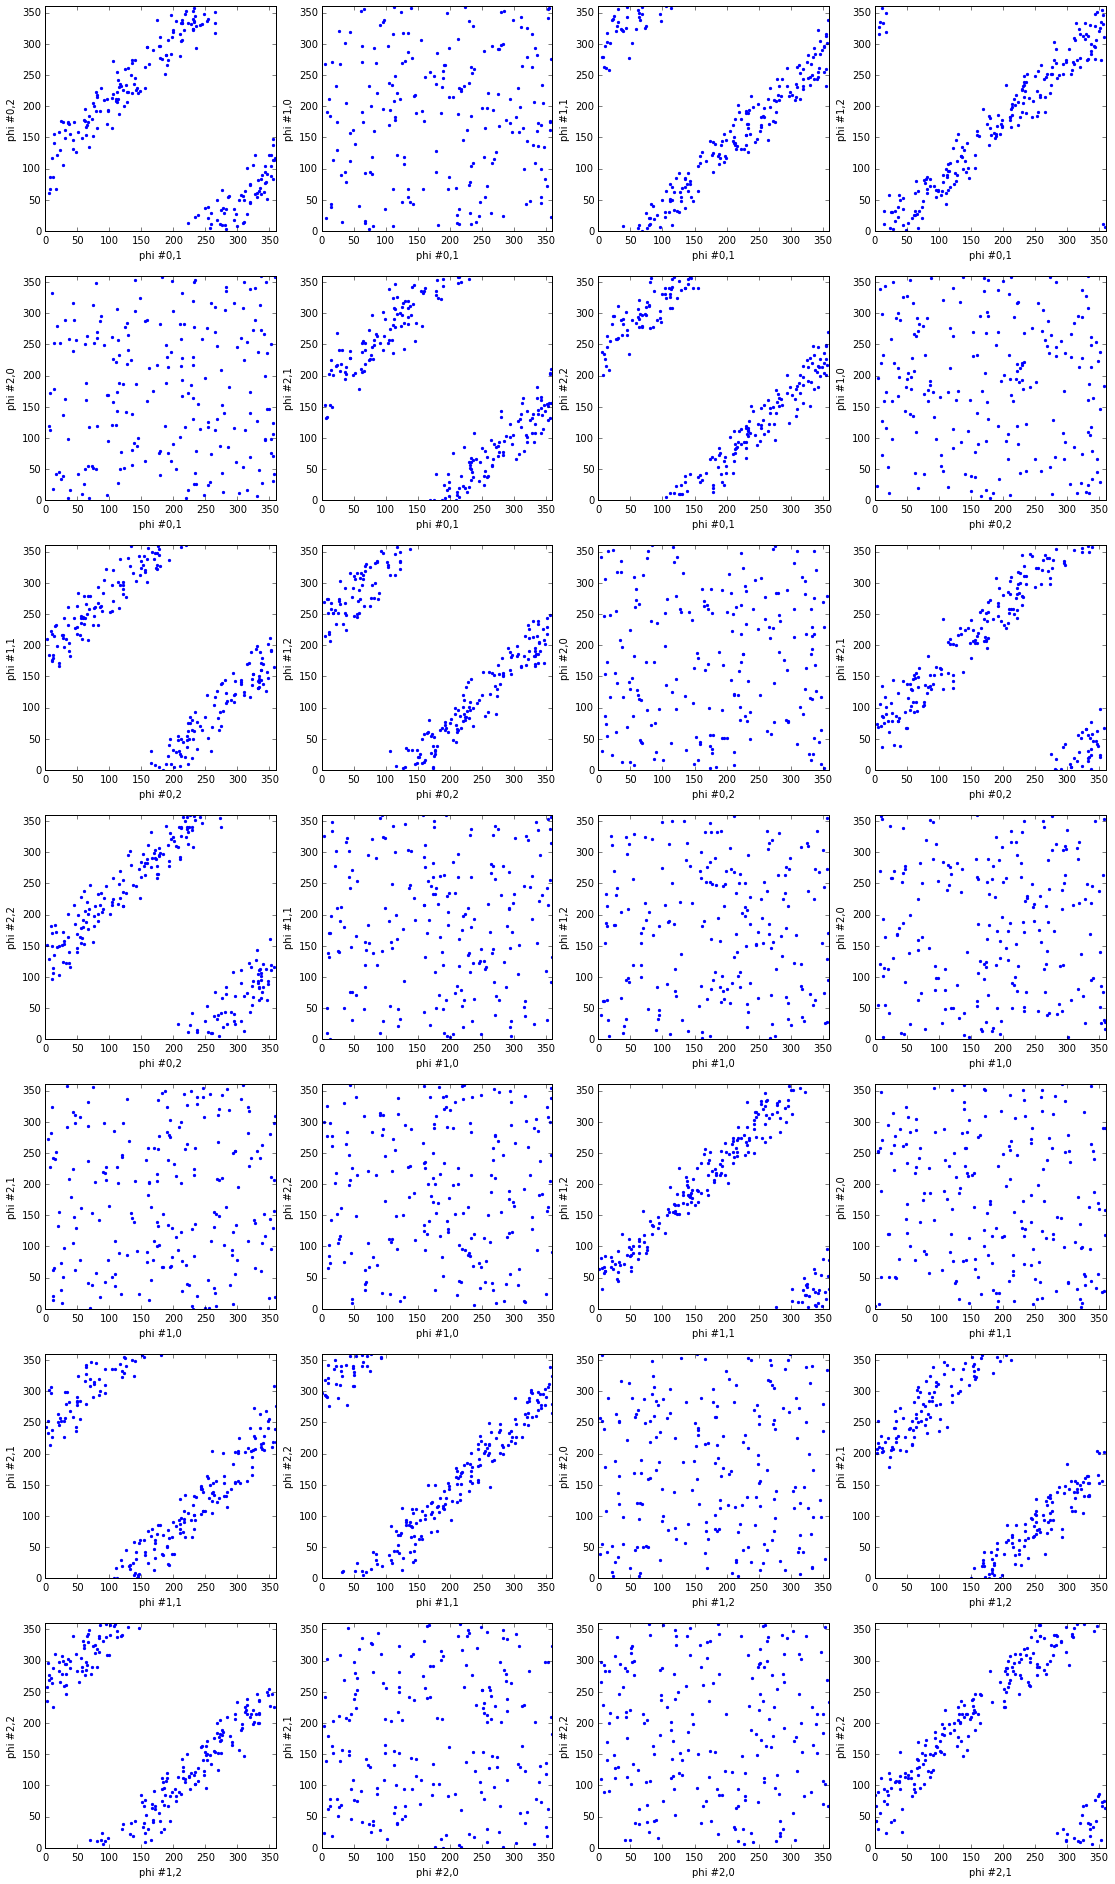

In [10]:
%matplotlib inline
THR2=64171 #choose a high-power thresholds 
THR=60000 #choose a low-power threshold

oo=G2DS #choose a dataset from G0DS, G1DS, G2DS, G3DS
oos=G2DSS #choose a dataset from G0DSS, G1DSS, G2DSS, G3DSS
oob=B2DS #choose a dataset from B0DS, B1DS, B2DS, B3DS
oobs=B2DSS #choose a dataset from B0DSS, B1DSS, B2DSS, B3DSS
saven='heyhey' #choose a savename

G2DSP=np.array(oos[len(np.extract(oo[:,9]<-THR2, oo)):len(np.extract(oo[:,9]<=-THR, oo))])
B2DSP=np.array(oobs[len(np.extract(oob[:,9]<-THR2, oob)):len(np.extract(oob[:,9]<=-THR, oob))])
fig, ax = plt.subplots(7,4,figsize=(19, 33))
PG2=np.array([np.array(G2DSP[:,phi]) for phi in range(8)])
PB2=np.array([np.array(B2DSP[:,phi]) for phi in range(8)])

phin=('phi #0,1','phi #0,2','phi #1,0','phi #1,1','phi #1,2','phi #2,0','phi #2,1','phi #2,2')

indax=0
for iii in itertools.product([0,1,2,3,4,5,6,7],repeat=2): #the for loop goes over all non-repeating combinations of phases
    if iii[0]<iii[1]:
        axtemp=ax[indax/4,np.mod(indax,4)]
        axtemp.set_xlabel(phin[iii[0]])
        axtemp.set_ylabel(phin[iii[1]])
        axtemp.set_xlim(0, 360)
        axtemp.set_ylim(0, 360)
        axtemp.scatter(PG2[iii[0]], PG2[iii[1]], color='blue', marker='.')
        axtemp.scatter(PB2[iii[0]], PB2[iii[1]], color='green', marker='o')
        indax=indax+1
#plt.savefig(saven)

### CONCLUSIONS: phi02 ~ phi01, phi11~phi01, phi12~phi01, phi21~phi01, phi22~phi01. This is 5 equations with three fee parameters phi01, phi10, phi20. So the high-power points live in a 3d hyperplane. The 5 steep direction would be calculated as (phi01+phi02), (phi01+phi11), etc...

### I tried interpolation to then compute an average hessian matrix but there are not enough sampling points

In [4]:
ff=intrp.NearestNDInterpolator(G2DSS[:,0:2],G2DS[:,9])

## Here I'm doing the same with 3d plots, not that enlightening but it basically shows that the maxima lie on a (2+epsilon)-d hyperplane, as PCA will confirm later.

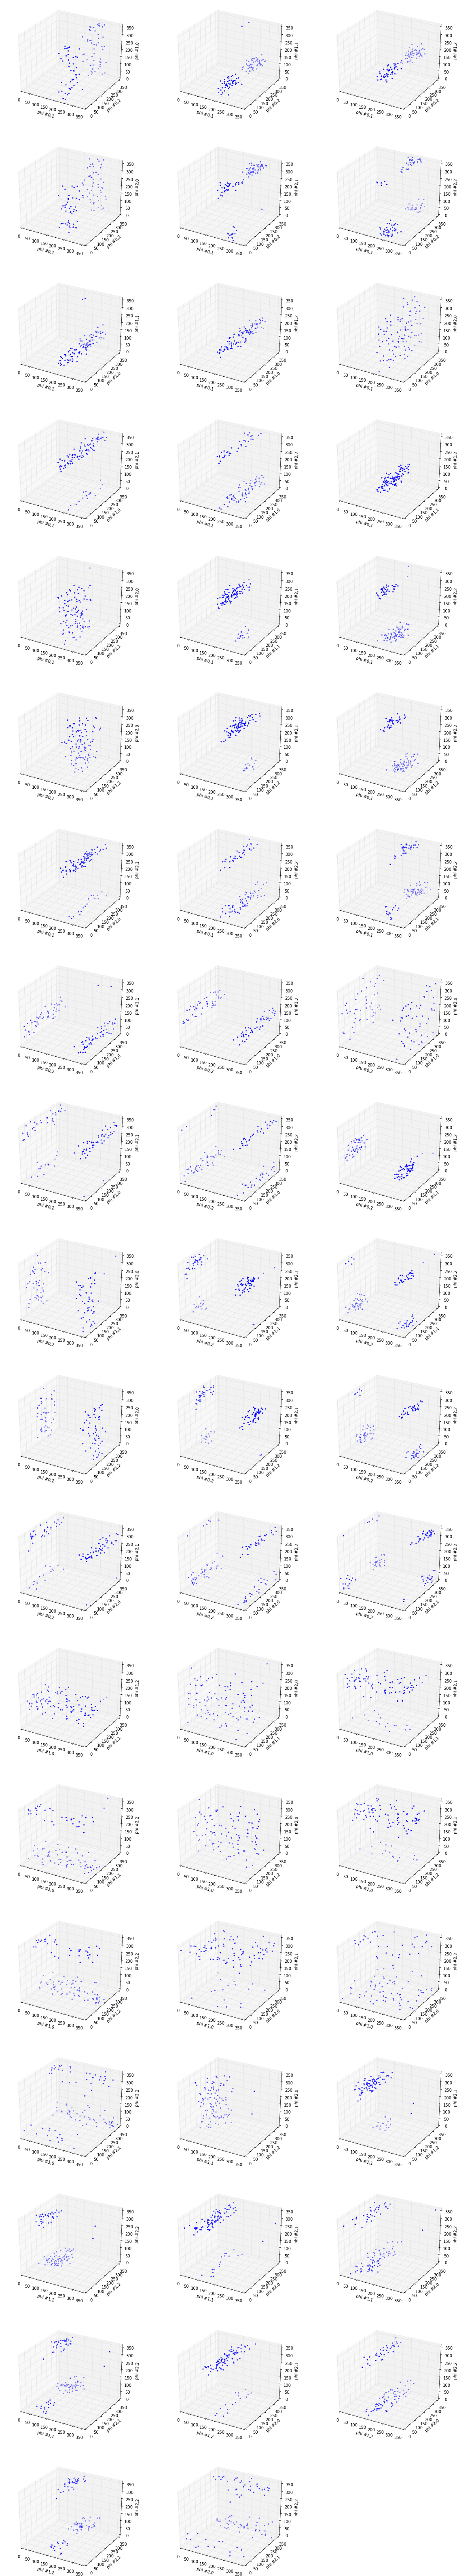

In [194]:
%matplotlib inline
THR2=650
THR=180

oos=G1DSS 
oo=G1DS

oop=np.array(oos[len(np.extract(oo[:,9]<-THR2, oo)):len(np.extract(oo[:,9]<=-THR, oo))])

fig = plt.figure(figsize=(20, 120))

#ax = fig.add_subplot(7, 4, 1,projection='3d')

oopp=np.array([np.array(oop[:,phi]) for phi in range(8)])

phin=('phi #0,1','phi #0,2','phi #1,0','phi #1,1','phi #1,2','phi #2,0','phi #2,1','phi #2,2')

#print(ax)

indax=0


for iii in itertools.product([0,1,2,3,4,5,6,7],repeat=3):#(np.array([0,1,2]),np.array([0,1,3]),np.array([0,2,3])):#
    if iii[0]<iii[1] and iii[1]<iii[2]:
        #axtemp=ax#[indax/4,np.mod(indax,4)]
        #axtemp=fig.add_subplot(1,indax/4, np.mod(indax,4), projection='3d')
        #axtemp=fig.add_subplot(1,indax+1, indax+1, projection='3d')
        axtemp=fig.add_subplot(20,3,indax+1, projection='3d')
        axtemp.set_xlabel(phin[iii[0]])
        axtemp.set_ylabel(phin[iii[1]])
        axtemp.set_zlabel(phin[iii[2]])
        axtemp.set_xlim3d(0, 360)
        axtemp.set_ylim3d(0, 360)
        axtemp.set_zlim3d(0, 360)
        axtemp.scatter(oopp[iii[0]], oopp[iii[1]],oopp[iii[2]], zdir='z',color='blue', marker='.')
        indax=indax+1
#plt.savefig('phi1vsphi2env2')

## As before but heatmap. Plus PCA.

[ 0.31400016  0.29813939  0.11989634  0.10343732  0.08591293  0.0551713
  0.01618988  0.00725267]


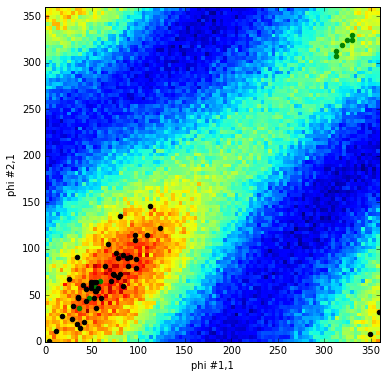

In [195]:
%matplotlib inline

#select which components to plot against one another
px=3
py=6

#shifto is a vector we manually shift by in order to center the maxima, to avoid periodicity effects and make PCA meaningful
#if all black dots in the plot below are lined up together in the square then PCA will give a reasonable result

#shifto=np.array([0,250,0,130,60,0,-65,-140]) # this should work for G1
shifto=np.array([0,0,0,0,0,0,0,0]) #no shift at all
#shifto=np.array([0,0,0,80,25,0,-170,130]) #this should work for G2


num=50 #select how many high-power points you want to use in PCA analysis
numg=50 #select how many high-power points you want to plot
numb=10 #select how many high-power beamform points you want to plot
oos=G3DS #as before
ooss=G3DSS #as before
oossb=B3DSS #as before 
saven='special' #choose a name to save the plot

#PCA analysis
pca=PCA(n_components=8)
pca.fit(np.mod(ooss[0:num]+shifto,360))
print(pca.explained_variance_ratio_)
#shows below the variance of the principal components, 3 components are enough to get most of the variance

#this was initially meant to rotate the components according to PCA but frankly such a rotation on an 8-torus 
#doesn't make sense

#roto=pca.components_
#roto=np.array([[(np.sqrt(2)/2),0,0,(-np.sqrt(2)/2),0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],
#               [np.sqrt(2)/2,0,0,np.sqrt(2)/2,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],
#               [0,0,0,0,0,0,0,1]])
roto=np.identity(8) #no rotation at all
oo=np.mod(ooss+shifto,360)
oob=np.mod(oossb+shifto,360)
bop=np.array([np.mod(np.dot(roto,ii),360) for ii in oo])
bopb=np.array([np.mod(np.dot(roto,ii),360) for ii in oob])

x=bop[:,px]
y=bop[:,py]

#PB1=np.mod(np.dot(roto,np.array([np.array(np.mod(B1DSS+shifto,360)[:,phi]) for phi in range(8)])))

plt.figure(figsize=(6,6))

denominator, xedges, yedges = np.histogram2d(y,x,range=[[0,360],[0,360]],bins=90) #heatmap needs binning
numerator, _, _ = np.histogram2d(y,x,bins=[xedges,yedges], weights=-oos[:,9]) 
extent=numerator/denominator

plt.subplot(1, 1, 1)
plt.xlabel(phin[px])
plt.ylabel(phin[py])
plt.axis([0., 360, 0, 360])

plt.pcolor(yedges,xedges,extent)
plt.scatter(bopb[0:numb,px], bopb[0:numb,py], color='green', marker='o')
plt.scatter(x[0:numg], y[0:numg], color='black', marker='o')
#black dots are general-solution high-power points
#green dots are beamform-solution high-power points

plt.savefig(saven)

#### CONCLUSION: the maxima lie on a 2-3 dim hyperplane, we can think of those 3 dimensions as the flattest dimensions for the power function and the remaining ones would be the steepest

### 3d heat map: this cell only runs if the one below is initialized, CAREFUL


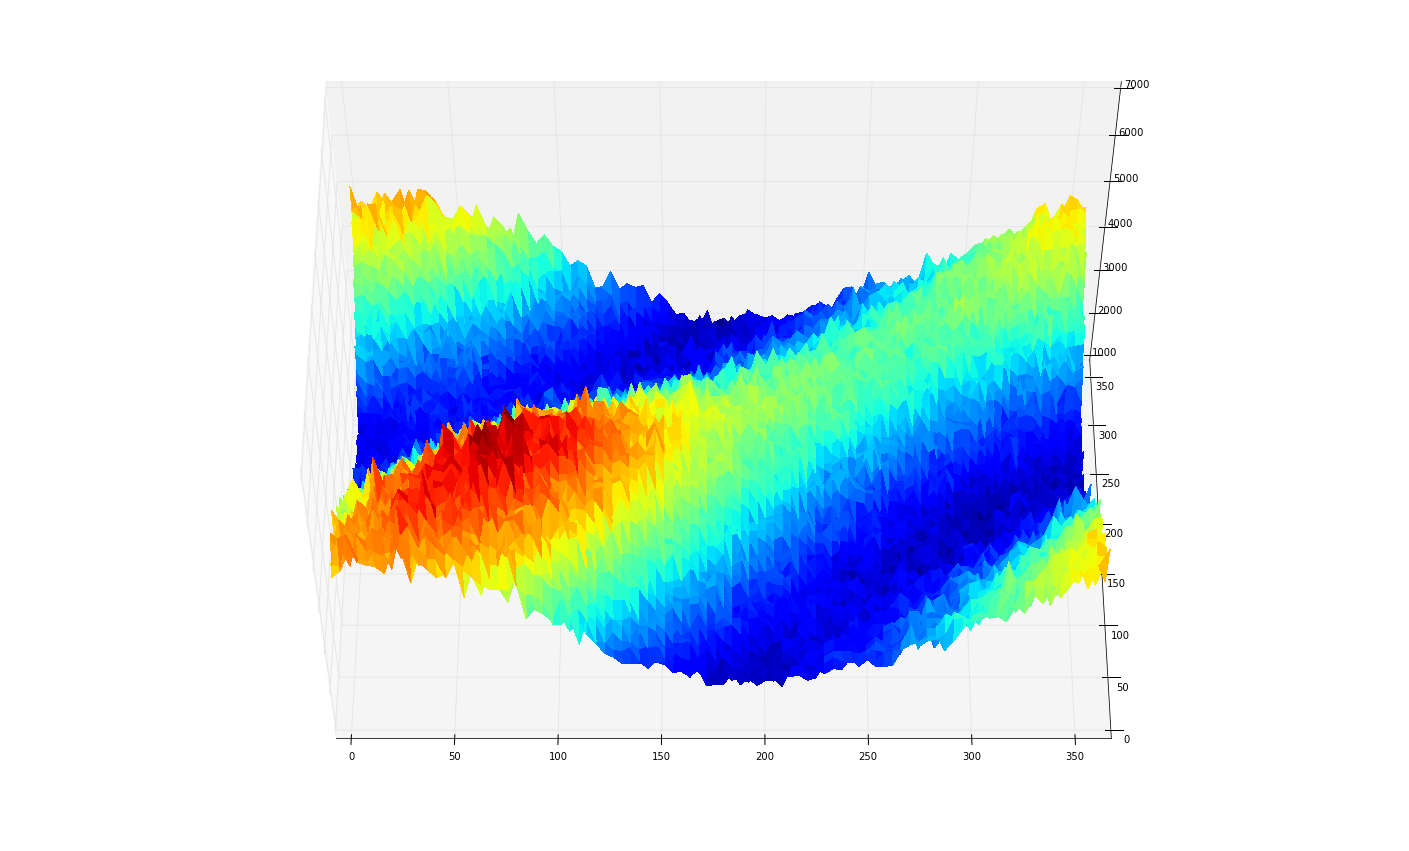

In [359]:
fig = plt.figure(figsize=(25,15))
ax = fig.gca(projection='3d')
X = yedges[0:90]
Y = xedges[0:90]
X, Y = np.meshgrid(X, Y)
Z = extent
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                       linewidth=0, antialiased=False)
ax.set_xlim(0, 360)
ax.set_ylim(0, 360)

ax.view_init(55, -90) 

#plt.savefig('landscape36')

# Conclusions: 
# I recommend implementing a gradient ascent algorithm in the 5 non-principal steep directions, followed by one in the 3 principal ones
# I also recommend exploring how the offset (vector 'shifto' above) depends on the room/environment/position of antenna/receiver
# Lastly, with a much finer sampling, a more systematic method (hessian) to run a "PCA" would be viable